# Exercise 08 RNN & NLP - Assignment - Solution

<span style="color:red">**The submission deadline of this assignment is February 23, 2025 at 23:59.**</span>

<span style="color:red">**In addition to the executed Jupyter Notebook, please also submit the saved `.pth` file of the trained CNN on Learn.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a text-classifier using LSTM.

The problem to be solved is to predict the class of a product based on the product page (title and description) on the E-commerce platform:

|Class|Example product page|
|-|-|
|Books|Inner Engineering: A Yogi's Guide to Joy About the Author Sadhguru Jaggi VasudevSADHGURU is a yogi, mystic, and visionary who established the Isha Foundation, a nonprofit dedicated to the cultivation of human potential...|
|Clothing & Accessories|Amour Butterfly Design Sunglasses For Girls 6+ Years { SKU16 } Amour Butterfly Design Sunglasses to give full protection. Very light weight. Highly durable. Its safe for kids eyes and give full eye protection against harmful uv rays...|
|Electronics|Bluetooth Dongle USB CSR 4.0 Adapter Receiver Transfer Wireless Adapter for PC Computer Laptop Supports Windows 10 8.1 8 7 Vista XP - Upgraded Version...|
|Household|Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch...|

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Create a LSTM-based text classifier
- Train the network,
- Reload the best model
- Evaluation using the test set
- Make predictions on unseen data

In [ ]:
classes = ['Books', 'Clothing & Accessories', 'Electronics', 'Household']

### Pre-configure

- Import necessary libraries
- Specify the computation device of PyTorch

In [ ]:
# [TBC] complete your code here with proper comments
# import libraries
import os
import warnings
import datetime


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import classification_report

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

# for padding a list of variable length tensors to equal length
from torch.nn.utils.rnn import pad_sequence
# for packing a tensor containing padded sequences of variable length
from torch.nn.utils.rnn import pack_padded_sequence

import nltk
# for removing stop words like 'the', 'and', etc
# stop words don't provide useful information
from nltk.corpus import stopwords
# for tokenization
from nltk.tokenize import word_tokenize

# for counting the number of unique tokens
from collections import Counter

In [ ]:
# suppress all warnings
warnings.filterwarnings("ignore")

In [ ]:
# get cpu, gpu or mps device for computation
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Task 1. Build the data pipeline

You are required to use `ecommerce_dataset.csv` which can be downloaded from the Learn Platform.

<span style="color:red">**[TBC]**</span> You need to:
- Load the dataset from the `ecommerce_dataset.csv` file
- Pre-process the text
    - Tokenization
    - Remove stop words (like 'and', 'the') that don't provide useful information
    - Remove non-alphabetic tokens
- Create the vocabulary
- Encode the tokens
- Create the Dataset and the Dataloader
    - Pad the tensors with variable lengths to equal length

In [ ]:
# [TBC] complete your code here with proper comments
# load dataset
df = pd.read_csv('ecommerce_dataset.csv')
df.head()

,text,label
0,Paper Plane Design Framed Wall Hanging Motivat...,3
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",3
2,SAF 'UV Textured Modern Art Print Framed' Pain...,3
3,"SAF Flower Print Framed Painting (Synthetic, 1...",3
4,Incredible Gifts India Wooden Happy Birthday U...,3


In [ ]:
# ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# set the stop words to the English mode
stop_words = set(stopwords.words('english'))

# define a function for pre-processing
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# apply preprocessing to the 'text' column
df['tokens'] = df['text'].apply(preprocess_text)

# build vocabulary
all_tokens = [token for tokens in df['tokens'] for token in tokens]
token_counts = Counter(all_tokens)
print('The number of unique tokens in the vocabulary:', len(token_counts))

# keep the most common token
vocab_size = 20000
common_tokens = token_counts.most_common(vocab_size - 2)  # Reserve two spots for PAD and UNK tokens
print('The number of most common tokens preserved:', vocab_size)

# create token to index mapping
token_to_idx = {token: idx+2 for idx, (token, _) in enumerate(common_tokens)}
# '<PAD>' is used to represent padding tokens at the end of text
token_to_idx['<PAD>'] = 0
# '<UNK>' is used to represent unknown tokens that are not included in the vocabulary
token_to_idx['<UNK>'] = 1

# create index to token mapping
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

# define a function for encoding
def encode_tokens(tokens):
    return [token_to_idx.get(token, token_to_idx['<UNK>']) for token in tokens]

# apply the encoding function to the 'tokens' column
df['encoded_tokens'] = df['tokens'].apply(encode_tokens)

[nltk_data] Downloading package punkt to /Users/tzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tzhang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


The number of unique tokens in the vocabulary: 60743
The number of most common tokens preserved: 20000


In [ ]:
# define a custom Dataset class to store the data as tensors
class AGNewsDataset(Dataset):
    def __init__(self, encoded_tokens_list, labels):
        self.encoded_tokens_list = encoded_tokens_list
        self.labels = labels

    def __len__(self):
        return len(self.encoded_tokens_list)

    def __getitem__(self, idx):
        X = self.encoded_tokens_list[idx]
        y = self.labels[idx]
        X = torch.tensor(X, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.long)
        return X, y

In [ ]:
# create the training, test and validation dataset
ds = AGNewsDataset(df['encoded_tokens'].values, df['label'].values)
train_val_ds, test_ds = random_split(ds, [0.7, 0.3])
train_ds, val_ds = random_split(train_val_ds, [0.8, 0.2])

In [ ]:
# define a collate function to pad the sequences in the same batch to equal length
# in addition to the padded_X and y, also return the length of X before padding
def collate_batch(batch):
    batch_X, batch_y, batch_length = [], [], []
    for (X, y) in batch:
        batch_X.append(X)
        batch_y.append(y)
        batch_length.append(len(X))
    batch_length = torch.tensor(batch_length, dtype=torch.int64)
    batch_y = torch.tensor(batch_y, dtype=torch.int64)
    # pad sequences to equal length
    batch_X = pad_sequence(batch_X, batch_first = True)
    return batch_X, batch_y, batch_length

In [ ]:
# create the training, validation, and test data loaders
batch_size = 512 # usually set to 2 to the nth power
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True, collate_fn = collate_batch)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False, collate_fn = collate_batch)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False, collate_fn = collate_batch)

## Task 2. Create a CNN-based image classifier

<span style="color:red">**[TBC]**</span> You need to:
- Define a custom class to specify the structure and the forward method of the network
    - You are required to use `nn.LSTM()` layer in the network
- Create an instance of the network and move it to the computation device

In [ ]:
# [TBC] complete your code here with proper comments
# define a custom neural network class
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_class):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_class)

    def forward(self, x, lengths):
        x = self.embedding(x)
        packed_x = pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        out, (h, c) = self.lstm(packed_x)
        return self.fc(h[-1])

# create the neural network
embed_size = 64
hidden_size = 32
num_class = 4
model = LSTMClassifier(vocab_size, embed_size, hidden_size, num_class)
model = model.to(device)

## Task 3. Train the network

<span style="color:red">**[TBC]**</span> You need to:
- Define a `train()` function
- Specify the training hyper-parameters
- Train the network
- Plot the loss history of the training process

In [ ]:
# [TBC] complete your code here with proper comments
# define the training function
def train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
):
    # initialization
    min_val_loss = np.inf
    patience_counter = 0
    histories = {
        'train_batch': [],
        'train_epoch': [],
        'val_batch': [],
        'val_epoch': []
    }
    saved_path = ''
    start_time = datetime.datetime.now()

    # start training
    for epoch in range(epochs):
        # train set
        train_epoch_loss = 0.0
        model.train()
        for X, y, lens in tqdm(train_dl, desc = f'Training batch\t'): # tqdm progress bar
            X, y, lens = X.to(device), y.to(device), lens.to(device)
            logits = model(X, lens)
            train_batch_loss = loss_fn(logits, y)
            train_batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            histories['train_batch'].append(train_batch_loss.item())
            train_epoch_loss += train_batch_loss.item()
        train_epoch_loss /= len(train_dl)
        histories['train_epoch'].append(train_epoch_loss)

        # validation set
        val_epoch_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X, y, lens in tqdm(val_dl, desc = f'Validation batch'): # tqdm progress bar
                X, y, lens = X.to(device), y.to(device), lens.to(device)
                logits = model(X, lens)
                val_batch_loss = loss_fn(logits, y)
                histories['val_batch'].append(val_batch_loss.item())
                val_epoch_loss += val_batch_loss.item()
            val_epoch_loss /= len(val_dl)
            histories['val_epoch'].append(val_epoch_loss)

        # print log
        end_time = datetime.datetime.now()
        time_consumed = str(end_time - start_time).split('.')[0]
        print(f"Epoch {epoch + 1}: train loss = {train_epoch_loss:>5f}, val loss = {val_epoch_loss:>5f}, time consumed = {time_consumed}")

        # learning rate decay
        current_lr = optimizer.param_groups[0]['lr']
        lr_scheduler.step(val_epoch_loss)
        new_lr = optimizer.param_groups[0]['lr']
        if current_lr != new_lr:
            print(f'Learning rate reduced after epoch {epoch+1}\n')

        # early stopping
        if val_epoch_loss < min_val_loss:
            min_val_loss = val_epoch_loss
            patience_counter = 0
            if os.path.exists(saved_path):
                os.remove(saved_path)
            time_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            saved_path = saved_path_prefix + f'_epoch_{epoch+1}_val_loss_{val_epoch_loss:>4f}_{time_str}.pth'
            torch.save(model.state_dict(), saved_path)
            print(f'Model saved after epoch {epoch+1}\n')
        else:
            patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print('Early stopping!')
            break
    return histories, saved_path

In [ ]:
# define the training hyper-parameters
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-1
weight_decay = 1e-5
optimizer = torch.optim.SGD(
    model.parameters(),
    lr = learning_rate,
    weight_decay = weight_decay
)
epochs = 1000
early_stopping_patience = 10
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 5
)
saved_path_prefix = 'ecommerce_classifier'

In [ ]:
# train the neural network
histories, saved_path = train(
    train_dl,
    val_dl,
    model,
    loss_fn,
    optimizer,
    epochs,
    early_stopping_patience,
    lr_scheduler,
    saved_path_prefix
)

Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.65it/s]


Epoch 1: train loss = 1.342090, val loss = 1.327258, time consumed = 0:02:10
Model saved after epoch 1



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.82it/s]


Epoch 2: train loss = 1.316541, val loss = 1.310292, time consumed = 0:04:08
Model saved after epoch 2



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.18it/s]


Epoch 3: train loss = 1.299428, val loss = 1.292098, time consumed = 0:06:04
Model saved after epoch 3



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.16it/s]


Epoch 4: train loss = 1.281122, val loss = 1.272943, time consumed = 0:07:56
Model saved after epoch 4



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.28it/s]


Epoch 5: train loss = 1.261815, val loss = 1.253801, time consumed = 0:09:50
Model saved after epoch 5



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.81it/s]


Epoch 6: train loss = 1.241640, val loss = 1.233956, time consumed = 0:11:43
Model saved after epoch 6



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.06it/s]


Epoch 7: train loss = 1.220124, val loss = 1.212759, time consumed = 0:13:39
Model saved after epoch 7



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.13it/s]


Epoch 8: train loss = 1.195910, val loss = 1.188874, time consumed = 0:15:34
Model saved after epoch 8



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.28it/s]


Epoch 9: train loss = 1.167216, val loss = 1.158001, time consumed = 0:17:27
Model saved after epoch 9



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.13it/s]


Epoch 10: train loss = 1.127864, val loss = 1.111743, time consumed = 0:19:22
Model saved after epoch 10



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.15it/s]


Epoch 11: train loss = 1.055121, val loss = 1.009857, time consumed = 0:21:17
Model saved after epoch 11



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.18it/s]


Epoch 12: train loss = 0.976770, val loss = 0.938505, time consumed = 0:23:10
Model saved after epoch 12



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.18it/s]


Epoch 13: train loss = 0.927311, val loss = 0.896168, time consumed = 1:11:50
Model saved after epoch 13



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.03it/s]


Epoch 14: train loss = 0.915755, val loss = 0.868675, time consumed = 1:13:46
Model saved after epoch 14



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.32it/s]


Epoch 15: train loss = 0.851310, val loss = 0.822867, time consumed = 1:15:39
Model saved after epoch 15



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.28it/s]


Epoch 16: train loss = 0.789495, val loss = 0.751184, time consumed = 1:17:34
Model saved after epoch 16



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.90it/s]


Epoch 17: train loss = 0.708551, val loss = 0.656992, time consumed = 1:19:30
Model saved after epoch 17



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.26it/s]


Epoch 18: train loss = 0.710973, val loss = 0.669525, time consumed = 1:21:26


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.16it/s]


Epoch 19: train loss = 0.680001, val loss = 0.581505, time consumed = 1:23:20
Model saved after epoch 19



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.11it/s]


Epoch 20: train loss = 0.655153, val loss = 0.663152, time consumed = 1:25:15


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.10it/s]


Epoch 21: train loss = 0.553079, val loss = 0.525103, time consumed = 1:27:08
Model saved after epoch 21



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.14it/s]


Epoch 22: train loss = 0.503972, val loss = 0.650753, time consumed = 1:29:04


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.04it/s]


Epoch 23: train loss = 0.646424, val loss = 0.855642, time consumed = 1:31:02


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.23it/s]


Epoch 24: train loss = 0.752275, val loss = 0.660886, time consumed = 1:32:57


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.20it/s]


Epoch 25: train loss = 0.537828, val loss = 0.490452, time consumed = 1:34:46
Model saved after epoch 25



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.21it/s]


Epoch 26: train loss = 0.481961, val loss = 0.416612, time consumed = 1:36:35
Model saved after epoch 26



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.14it/s]


Epoch 27: train loss = 0.387048, val loss = 0.381911, time consumed = 1:38:23
Model saved after epoch 27



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.15it/s]


Epoch 28: train loss = 0.439044, val loss = 0.385428, time consumed = 1:40:14


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.23it/s]


Epoch 29: train loss = 0.357033, val loss = 0.357710, time consumed = 1:42:04
Model saved after epoch 29



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.09it/s]


Epoch 30: train loss = 0.333971, val loss = 0.444747, time consumed = 1:43:56


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.25it/s]


Epoch 31: train loss = 0.319980, val loss = 0.340580, time consumed = 2:00:35
Model saved after epoch 31



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.27it/s]


Epoch 32: train loss = 0.306123, val loss = 0.320985, time consumed = 2:02:24
Model saved after epoch 32



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.40it/s]


Epoch 33: train loss = 0.345684, val loss = 0.349859, time consumed = 2:04:10


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.18it/s]


Epoch 34: train loss = 0.324003, val loss = 0.327948, time consumed = 2:05:59


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.14it/s]


Epoch 35: train loss = 0.282552, val loss = 0.310346, time consumed = 2:07:49
Model saved after epoch 35



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.01it/s]


Epoch 36: train loss = 0.264401, val loss = 0.306181, time consumed = 2:09:41
Model saved after epoch 36



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.08it/s]


Epoch 37: train loss = 0.271404, val loss = 0.299528, time consumed = 2:11:33
Model saved after epoch 37



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.79it/s]


Epoch 38: train loss = 0.256967, val loss = 0.289518, time consumed = 2:13:21
Model saved after epoch 38



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.03it/s]


Epoch 39: train loss = 0.243863, val loss = 0.283710, time consumed = 2:15:12
Model saved after epoch 39



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.07it/s]


Epoch 40: train loss = 0.243257, val loss = 0.283711, time consumed = 2:16:59


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.19it/s]


Epoch 41: train loss = 0.227264, val loss = 0.276647, time consumed = 2:18:48
Model saved after epoch 41



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.91it/s]


Epoch 42: train loss = 0.225898, val loss = 0.273474, time consumed = 2:20:38
Model saved after epoch 42



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.00it/s]


Epoch 43: train loss = 0.217296, val loss = 0.267656, time consumed = 2:22:29
Model saved after epoch 43



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.08it/s]


Epoch 44: train loss = 0.210783, val loss = 0.265663, time consumed = 2:24:18
Model saved after epoch 44



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.17it/s]


Epoch 45: train loss = 0.647301, val loss = 1.032423, time consumed = 2:26:07


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.78it/s]


Epoch 46: train loss = 0.830969, val loss = 0.709436, time consumed = 2:27:58


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.11it/s]


Epoch 47: train loss = 0.699721, val loss = 0.655574, time consumed = 2:29:48


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.03it/s]


Epoch 48: train loss = 0.627709, val loss = 0.623583, time consumed = 2:31:36


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.17it/s]


Epoch 49: train loss = 0.656418, val loss = 0.621545, time consumed = 2:33:27


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.26it/s]


Epoch 50: train loss = 0.595802, val loss = 0.606909, time consumed = 2:35:19
Learning rate reduced after epoch 50



Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.17it/s]


Epoch 51: train loss = 0.573759, val loss = 0.595951, time consumed = 2:37:09


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.94it/s]


Epoch 52: train loss = 0.570971, val loss = 0.594454, time consumed = 2:38:56


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.10it/s]


Epoch 53: train loss = 0.569518, val loss = 0.592573, time consumed = 2:40:46


Validation batch: 100%|████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.11it/s]

Epoch 54: train loss = 0.567415, val loss = 0.590902, time consumed = 2:42:35
Early stopping!


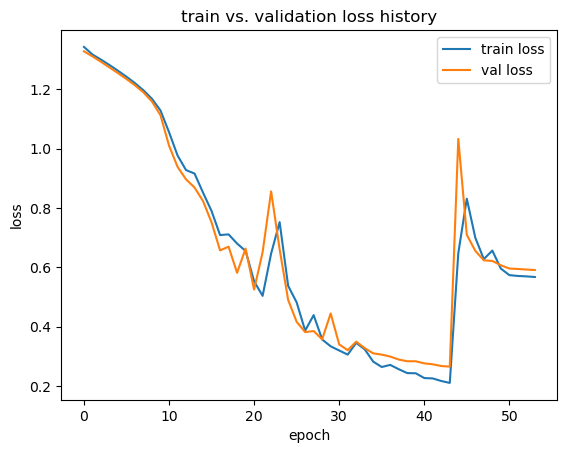

In [ ]:
# plot the train vs. val loss history
plt.figure()
plt.plot(np.arange(len(histories['train_epoch'])), histories['train_epoch'], '-', label = 'train loss')
plt.plot(np.arange(len(histories['val_epoch'])), histories['val_epoch'], '-', label = 'val loss')
plt.title('train vs. validation loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Task 4. Reload the best model

<span style="color:red">**[TBC]**</span> You need to:
- Reload the best trained model saved during the training process
- Move the reloaded model to the computation device

In [ ]:
# [TBC] complete your code here with proper comments
# reload the best model
model.load_state_dict(torch.load(saved_path))
model.to(device)

LSTMClassifier(
  (embedding): Embedding(20000, 64)
  (lstm): LSTM(64, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)

## Task 5. Test and evaluation

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
    - Output logits, probabilities and predictions
    - Output the loss value on the test set
- Make predictions on the test dataset
- Evaluate the performance
    - Use `sklearn.metrics.classification_report()`

In [ ]:
# [TBC] complete your code here with proper comments
# define a function to make predictions on test dataset and evaluate the performance
def test(dataloader, model, loss_fn):
    logits, probs, preds = [], [], []
    with torch.no_grad():
        loss = 0.0
        for (X, y, lens) in dataloader:
            X, y, lens = X.to(device), y.to(device), lens.to(device)
            batch_logits = model(X, lens)
            batch_loss = loss_fn(batch_logits, y)
            loss += batch_loss.item()

            batch_probs = torch.softmax(batch_logits, dim = -1)
            _, batch_preds = torch.max(batch_logits, 1)

            logits.append(batch_logits.cpu().numpy())
            probs.append(batch_probs.cpu().numpy())
            preds.append(batch_preds.cpu().numpy())
        loss /= len(dataloader)
        print(f"test loss = {loss}")
    return np.concatenate(logits), np.concatenate(probs), np.concatenate(preds), loss

In [ ]:
# make prediction on test set and evaluate the performance
test_logits, test_prob, test_pred, test_loss = test(test_dl, model, loss_fn)

# obtain test labels
test_label = []
for (_, y, _) in test_dl:
    test_label.extend(y.cpu().numpy())

print(classification_report(test_label, test_pred, target_names = classes))

test loss = 0.22163906892140706
                        precision    recall  f1-score   support

                 Books       0.95      0.94      0.94      3515
Clothing & Accessories       0.97      0.95      0.96      2613
           Electronics       0.93      0.93      0.93      3151
             Household       0.94      0.95      0.94      5847

              accuracy                           0.94     15126
             macro avg       0.95      0.94      0.94     15126
          weighted avg       0.94      0.94      0.94     15126



## Task 6. Make predictions on unseen text

<span style="color:red">**[TBC]**</span> You need to:
- Define a `predict_text()` function
- Specify an unseen product page by yourself
    - Use a real product page on the ecommerce platform as Amazon
    - Or make up a fake one yourself
- Make predictions and display the results

In [ ]:
# [TBC] complete your code here with proper comments
# define a function to predict the classes of a list of text
def predict_text(model, text_list):
    X, lens = [], []
    for text in text_list:
        tokens = preprocess_text(text)
        encoded_tokens = encode_tokens(tokens)
        X.append(torch.tensor(encoded_tokens, dtype=torch.int64))
        lens.append(len(encoded_tokens))
    X = pad_sequence(X, batch_first=True)
    lens = torch.tensor(lens, dtype=torch.int64)
    with torch.no_grad():
        logits = model(X.to(device), lens.to(device))
        _, preds = torch.max(logits, 1)
    return preds.cpu().numpy()

In [ ]:
# example texts
text_list = [
    "Redmi Y2 (Dark Grey, 4GB RAM, 64GB Storage).",
    "The Courage To Be Disliked Paperback – 3 Jan. 2019.",
    "Urban Classics Basic Crew Neck Tall Tee Men's T-Shirt.",
    "Chanteclair - Intense and Persistent White Musk Linen Fragrance, 22 Doses - 220 ml."
]
# make prediction
preds = predict_text(model, text_list)
# print results
for idx in range(len(text_list)):
    text = text_list[idx]
    pred = preds[idx]
    print(f'Text: {text}\nPredicted category: {classes[pred]}\n')

Text: Redmi Y2 (Dark Grey, 4GB RAM, 64GB Storage).
Predicted category: Electronics

Text: The Courage To Be Disliked Paperback – 3 Jan. 2019.
Predicted category: Books

Text: Urban Classics Basic Crew Neck Tall Tee Men's T-Shirt.
Predicted category: Clothing & Accessories

Text: Chanteclair - Intense and Persistent White Musk Linen Fragrance, 22 Doses - 220 ml.
Predicted category: Household

